# Actions over time

<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S32_vacuum_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U -q gtbook


Note: you may need to restart the kernel to use updated packages.


In [2]:
import gtsam

import gtbook
import gtbook.display
from gtbook import vacuum
from gtbook.discrete import Variables

VARIABLES = Variables()
def pretty(obj):
    return gtbook.display.pretty(obj, VARIABLES)
def show(obj, **kwargs):
    return gtbook.display.show(obj, VARIABLES, **kwargs)

# From section 3.1:
X = VARIABLES.discrete_series("X", [1], vacuum.rooms)
state_prior = gtsam.DiscreteDistribution(X[1], "0/0/1/0/0")


```{index} action; stochastic action
```

> Using the language of probability to describe systems with uncertainty in the effects of actions.

<img src="Figures3/S32-iRobot_vacuuming_robot-04.jpg" alt="Splash image with vacuuming robot in action" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

```{index} conditional probability distribution
```
In the real world, robots do not always execute actions perfectly, for a
variety of reasons. 
To model the uncertainty when executing an action, we will once again use the
language of probability. 
We will use *conditional probability distributions* to model how we can affect the state 
of the robot by actions. 
Recall that in Chapter 2 we used conditional probabilities to model
the effects of uncertainty in sensing at a specific moment in time.
Here, we use conditional probabilities to model the uncertainty in state transitions when
actions are executed.

```{index} graphical model
```
We can model this using graphs, with directed edges that specify conditional
probabilities on variables.
We can use these "graphical models" to generate sample system trajectories
for a fixed sequence of actions.
Such sample trajectories can be used for planning, as we will see later in the chapter.
In addition, the graphical model approach allows us to easily extend probabilistic actions to
factored state representations, which can provide significant computational advantages.

```{index} action space
```
In our example, we assume that our robot is equipped with navigation software that implements four
primitive actions: *move left, move right, move up, move down*,
which we will denote by *L,R,U,D*.
Together, these four actions define the **action space**.
The nominal effects of these actions (i.e., the effects of the actions without taking into account uncertainty) 
are to move the robot from the current room to an adjacent
room, according to the direction specified by the action.
For example, executing the *move down* action from the living room should take the robot into the hallway.


<figure id="fig:Stochastic">
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/S32-Actions.png?raw=1" style="width:14cm" alt="" />
<figcaption>Our robot is equipped with
four primitive actions: Left, Right, Up, and Down.
</figcaption>
</figure>

We can represent these actions graphically by making a slight modification to our state space graph
from the previous section.
Instead of using undirected edges to denote adjacency, each action contributes a directed edge, as shown in 
Figure [1](#fig:Stochastic).
Note that to simplify notation  we use *L,R,U,D*
instead of *move left, move right, move up, move down* to label the edges.

## Probabilistic Outcomes of Actions

> Actions are uncertain.

<figure id="fig:Mud">
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Mud.png?raw=1" style="width:14cm" alt="" />
<figcaption>Mobile robot driving in mud.</figcaption>
</figure>

In the real world, robots do not always execute actions perfectly, for a variety of reasons.
For example, as shown in Figure [2](#fig:Mud),
a robot may attempt to drive forward in an outdoor environment but mud
under its wheels might prevent it from traveling as far as desired.

<figure id="fig:Pickup">
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/N3-Pick.png?raw=1" style="width:14cm" alt="" />
<figcaption>A humanoid attempting to pick up an object.</figcaption>
</figure>

Or a robot with an articulated arm (Figure [3](#fig:Pickup))
might attempt to pick up an object, but fail. Some objects are easier to grasp than others, and robot grippers are not as dexterous as human hands, so this is not such a rare occurrence.

Similarly, for our vacuum cleaning robot example, a variety of things could go wrong: a particular doorway might be blocked, the robot might get lost, or it might take an action that is simply not available in a particular room - for example executing *move up* in the office.
As a reminder, in this chapter we *discretize* time and talk about the state of the robot at discretized times $t_k$, with $k\geq1$ an integer. Here we don't care too much about the underlying times $t_k$ at which the robot finishes a transition, as long as it is in a reasonable time. For example, the robot control system could time out after several unsuccessful attempts to move to a different room. That is then another way an action can fail.

```{index} state transition model, motion model
```
To model the uncertainty associated with executing an action, we will once again use the language of probability. 
In particular, we will use the conditional probability $P(X_{k+1}|X_k=x,A=a)$ to define
the **state transition model**  model, i.e.,
the conditional probability distribution for the next state $X_{k+1}$, 
given the value $x$ of the current state $X_k$, and the value $a$ of the action $A$. 
Because the state space in this case involves navigation, we could also call the corresponding conditional distribution 
$P(X_{k+1}|X_k,A)$ a **motion model**.

The code in Figure [4](#vacuum-motion-model) generates a motion model for moving from state $X_1$ to $X_2$ in the
form of a large conditional probability table. In the code, we make use of two new variables (`action_space` and `action_spec`) that were predefined for us but are repeated here in the comment for clarity. The `motion_model` is rendered as a table below the code, showing $P(X_2|X_1,A_1)$ as a row for all possible $(X_1,A_1)$ combinations.

In [3]:
#| caption: The code for specifying the vacuum cleaner motion model, and the resulting CPT.
#| label: vacuum-motion-model
# vacuum.action_space = ["L","R","U","D",]
# vacuum.action_spec is a string with the transition probabilities:
#  "1/0/0/0/0 2/8/0/0/0 1/0/0/0/0 2/0/0/8/0
#   8/2/0/0/0 0/1/0/0/0 0/1/0/0/0 0/2/0/0/8
#   0/0/1/0/0 0/0/2/8/0 0/0/1/0/0 0/0/1/0/0
#   0/0/8/2/0 0/0/0/2/8 8/0/0/2/0 0/0/0/1/0
#   0/0/0/8/2 0/0/0/0/1 0/8/0/0/2 0/0/0/0/1"
X = VARIABLES.discrete_series("X", [1, 2, 3], vacuum.rooms) # states for times 1,2 and 3
A = VARIABLES.discrete_series("A", [1, 2], vacuum.action_space) # actions for times 1 and 2
motion_model = gtsam.DiscreteConditional(X[2], [X[1], A[1]], vacuum.action_spec)
pretty(motion_model)

X1,A1,Living Room,Kitchen,Office,Hallway,Dining Room
Living Room,L,1,0,0,0,0
Living Room,R,0.2,0.8,0,0,0
Living Room,U,1,0,0,0,0
Living Room,D,0.2,0,0,0.8,0
Kitchen,L,0.8,0.2,0,0,0
Kitchen,R,0,1,0,0,0
Kitchen,U,0,1,0,0,0
Kitchen,D,0,0.2,0,0,0.8
Office,L,0,0,1,0,0
Office,R,0,0,0.2,0.8,0


It is of course rather tedious to specify this table by hand.
In this case, for each of the four actions, we must compute a transition probability from
each of the five possible starting rooms to each of the five possible destination rooms:
$4*5*5=100$ entries.
In the example above, impossible transitions (e.g., moving up from the living room to any other room)
are assigned zero probability.
Other actions are assumed to have 80% chance of success (e.g., moving right from the living room
and arriving to the kitchen is assigned a transition probability of $0.8$).

Conditional probability distributions do not *have* to be specified as giant
tables. Because the state space is potentially quite large, such a
motion model is almost never explicitly specified, but
rather exploits the semantics of the states and actions to calculate the conditional distribution at run-time.
For example, rather than enumerate every possible action from every possible room, we might
determine the probability of successfully moving to an adjacent room is $0.8$, for all
rooms and for all actions, and that the probability of failing to do so is $0.2$.
If we apply this rule to each combination of action and adjacent rooms, we can
construct specific rows the table above on an as-needed basis.

### Exercises

1.  Even though the CPT above
    has 100 numbers in it, how many *independent* numbers do we
    actually have when specifying this CPT?

2.  Specify a *parametric* conditional density for the action models for
    the vacuuming robot that is somewhat realistic, yet not completely
    deterministic.

3.  It is possible to create models that do not reflect everyday
    physics. For example, how could we model the game “Portal”?

## Understanding Sequences of Actions

> From one to many actions.

How do we use the above to predict what happens when taking *multiple* actions?
Formally, assume we apply a sequence of actions $a_1 \dots a_k$, and we wish to compute the probability distribution associated with the resulting state $X_{k+1}$.
Below, we accomplish this by applying the law of total probability.

```{index} law of total probability
```
The **law of total probability** provides a convenient way to compute the probability of an event by considering all of the different ways the event could occur.
Suppose we have a set of events ${\cal B} = \{B_1, \dots , B_n\}$ such that $B_i \cap B_j = \emptyset$ when $i \neq j$,
and with $\cup B_i = \Omega$, i.e., the set of events ${\cal B}$ forms a partition of the sample space.
To compute the probability of an event $A$, the law of total probability is given by
\begin{equation}
P(A) = \sum_{i} P(A | B_i ) P(B_i)
\end{equation}
We merely sum the conditional probabilities $P(A | B_i)$ for each event $B_i$, weighted by the probability of the event $B_i$.

We can use the law of total probability to compute the probability that the robot
is in state $x_{k+1}$ at time step $k+1$ by conditioning on the possible states for time step $k$:
\begin{equation}
P(X_{k+1} = x_{k+1}) = \sum_{x_k} P(X_{k+1} = x_{k+1}| X_k = x_k) P(X_k = x_k).
\end{equation}
Now, condition every term in the above equation on the sequence of actions $a_1 \dots a_k$, and we obtain
\begin{equation}
P(X_{k+1} | a_1 \dots a_k) = \sum_{x_k} P(X_{k+1} | X_k, a_1 \dots a_k) P(X_k|a_1 \dots a_k),
\end{equation}
where, for brevity's sake, we omit the explicit assignment of values to $X_k$ and $X_{k+1}$.

```{index} posterior
```
This expression may seem complex, but it can be simplified by making the following observation:
*If we know that the robot is in a specific state $x_k$ at time step $k$, then the next state will depend only
on the action executed at time step $k$; the previously executed actions will not affect our belief
about $X_{k+1}$*.
For example, if the robot executes the action *move down* knowing with certainty that it is in the living room at time step $k$,
the sequence of actions that brought the robot to the living room (i.e., actions $a_1 \dots a_{k-1}$) does not affect our belief
about whether the robot will arrive to the hallway.
Mathematically, we can write this relationship as follows:
\begin{equation}
P(X_{k+1} | X_k, a_1 \dots a_k) = P(X_{k+1} | X_k, a_k)
\end{equation}
We can also simplify the term $P(X_k |a_1 \dots a_k)$.
Notice that the action performed at time step $k$ has no affect on the state at time step $k$.
For example, if the robot executes the *move down* action
in the living room at time step $k$, this actions does not change the fact that the robot was in the living room
at time *t*.
Therefore, we have
\begin{equation}
P(X_k |a_1 \dots a_k) = P(X_k |a_1 \dots a_{k-1})
\end{equation}
Applying these two simplifications, we obtain the final form for the desired probability distribution $P(X_{k+1} | a_1 \dots a_k)$:
\begin{equation}
P(X_{k+1} | a_1 \dots a_k) = \sum_{x_k} P(X_{k+1} | X_k, a_k) P(X_k |a_1 \dots a_{k-1})
\end{equation}
We can think of the terms in this expression as follows:
- $P(X_k |a_1 \dots a_{k-1})$ is the prior over the current state $X_k$;
- $P(X_{k+1} | X_k, a_k)$ is the motion model;
- $P(X_{k+1} | a_1 \dots a_k)$ is the **posterior** over the next state $X_{k+1}$.

For the initial state, no actions have yet been applied, and the prior is merely 
the prior $P(X_1)$ over the initial state $X_1$.
And then the posterior at time step $k=2$ can be computed as
\begin{equation}
P(X_{2}| a_1) = \sum_{x_1} P(X_{2} | X_1, a_1) P(X_1).
\end{equation}
This posterior $P(X_{2}| a_1)$ then becomes the prior in the next step, and so forth... This is one example of computing probability distributions recursively, a scheme which we will encounter many times more.


## State Transition Matrices and the Belief State

> It's an elementary matrix multiply, my dear Watson.

```{index} belief state
```
In order to specify the complete posterior distribution at time step $k+1$, we would need to perform the calculation above five times, once for each of the possible next states ($L,K,O,H,D$), i.e., all the rooms in the house we could end up in after taking the action sequence.
This complete distribution is called the **belief state** $b_{k+1}$, defined as the *row vector*
\begin{equation}
b_{k+1} = \begin{bmatrix}
P(X_{k+1} = L | a_{1:k})\\
P(X_{k+1} = K | a_{1:k})\\
P(X_{k+1} = O | a_{1:k})\\
P(X_{k+1} = H | a_{1:k})\\
P(X_{k+1} = D | a_{1:k})
\end{bmatrix}^T
\end{equation}
in which we have simplified notation by using the notation
$a_{1:k} \doteq a_1, \dots, a_k$.

```{index} state transition matrix
```
We can write the equations for the belief state in a compact form by writing the conditional probability tables as
transition matrices.
To do so, for each action, we merely gather the corresponding rows from the complete conditional probability
table into a state transition matrix.
For the action *move right*, this is illustrated below in Figure [5](#fig:TM).

<figure id="fig:TM">
<img src="https://github.com/gtbook/robotics/blob/main/Figures3/S32-transition-matrix.png?raw=1" style="width:20cm" alt="" />
<figcaption>The transition matrix for the action *move right*.
</figcaption>
</figure>

```{index} belief transition function
```
If we apply the action *move right* to the initial state, by straightforward calculations, we can see that $b_2 = b_1 M_r$, i.e., a simple vector-matrix multiply.
This can be generalized to a sequence of actions.
If we execute action ${\cal A}_k$ at time step $k$,
the belief state $b_{k+1}$ is given by
\begin{equation}
b_{k+1} = b_k M_{{\cal A}_k}.
\end{equation}
Above $M_{\cal A}$ is the conditional probability matrix for action $\cal A$ and $b_k$ is the belief state at time step $k$.
We refer to this equation as a *belief transition function* -- given the
belief at time step $k$ and the action $a_k$, it can be applied to compute the belief at time step $k+1$.
This result can be applied recursively to yield
\begin{equation}
b_{k+1} = b_1 M_{{\cal A}_1} \dots M_{{\cal A}_k}
\end{equation}

### Exercise

Implement the above in python and observe how the belief state evolves from various initial belief states.

## Controlled Markov Chains

> Markov chains are everywhere. Actions control them.

```{index} Markov property
```
In the derivation above of the belief transition function we employed a temporal decoupling property,
namely, given the state at time step $k$, all actions that were applied prior to time step $k$ were irrelevant
to determining the belief state $b_{k+1}$.
This is an example of what is called the **Markov property**.
Variations of this property
are essential for reducing the amount of computation required to reason probabilistically over long periods of time.

```{index} Markov chain
```
The most common example of this property arises in systems that are called Markov chains.
In its simplest form, a **Markov chain** is a sequence of random variables, $X_1, X_2, \dots $
for which, for every $k$, we have
\begin{equation}
P(X_{k+1} | X_1 \dots X_k) = P(X_{k+1} | X_k).
\end{equation}

For Markov chains, knowledge of $X_k$ completely decouples the past (i.e., $X_1 \dots X_{k-1}$) from the future (i.e., $X_{k+1}$).
Therefore, when reasoning about future states, we need not perform computations over the entire history of the system: if we know $X_k$, we need only perform computations related to the present when reasoning about the future.

Markov chains have a nice graphical representation.
Each node corresponds to a random variable,
and directed edges specify conditional probabilities.
As an application, we can use this simple graphical model to represent
the probabilistic transitions between states, and in fact it can be generated in code,
as seen in Figure [6](#fig:markov_chain_3).

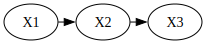

In [4]:
#| caption: A simple three state Markov chain.
#| label: fig:markov_chain_3
N = 3
X = VARIABLES.discrete_series("X", range(1, N+1), vacuum.rooms) # states for times 1...N
markov_chain = gtsam.DiscreteBayesNet()
markov_chain.add(state_prior)
for k in range(1, N):
    markov_chain.add(X[k+1], [X[k]], "6/1/1/1/1 1/6/1/1/1 1/1/6/1/1 1/1/6/1/1 1/1/1/1/6")
show(markov_chain, hints={"X":1})

Each node in this graph denotes a random variable, and therefore each node has an associated probability distribution.
If we know the distribution for the initial state $X_1$, we can recursively compute the distributions for the states $X_k$ for all $k > 1$, by evaluating the conditional distributions associated to the directed edges in the graph.

```{index} controlled Markov chain
```
Our robot vacuum cleaner is slightly more sophisticated than this simple Markov chain, since
the robot has the ability to execute actions, and these actions affect the propagation
of probabilities through the chain.
This type of system is called a **controlled Markov chain**, since it incorporates
a control input (the actions) into the usual Markov chain.

Graphically, we can represent such a system by augmenting the graph above to include nodes that denote actions.
We use a *box* to denote nodes whose values are known.
Since the robot knows which actions it executes, action nodes are denoted by boxes.
For our vacuuming robot, we also know the value of the initial state,
since the robot always begins in the office.
Therefore, we also use a box to denote the initial state in this graph.

As an example, the code in Figure [7](#fig:bayes_net_fragment) builds the controlled Markov chain for a single step of our system, i.e., up to time step $k=2$.

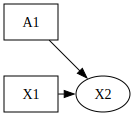

In [5]:
#| caption: A Bayes net fragment modeling the effect of an action on the state.
#| label: fig:bayes_net_fragment
action_prior = gtsam.DiscreteDistribution(A[1], "1/1/1/1")
fragment = gtsam.DiscreteBayesNet()
fragment.add(motion_model)
show(fragment, hints={"A": 2, "X": 1}, boxes={A[1][0], X[1][0]})

By applying the belief transition equation above, we can compute the posterior probability $P(X_2|a_1)$ over $X_2$,
since the action $a_1$ and the initial state $x_1$ are both completely known. 
Given values for the parent variables $A_1$ and $X_1$, we can examine the corresponding transition probability. 

The code in Figure [8](#fig:apply_motion_model) shows how to implement this, using the variable `motion_model` we defined early on in this section.
In the example, if we start from the $x_1=\text{Office}$ and attempt to go right, i.e., action $a_1=\text{R}$, we obtain the probability over the next state $X_2$, showing that we move to the hallway with 80% probability, and stay in the office with 20% probability.

In [6]:
#| caption: The result of applying the motion model to a specific state and action.
#| label: fig:apply_motion_model
values = VARIABLES.assignment({X[1]: "Office", A[1]: "R"})
pretty(motion_model.choose(values))

X2,value
Living Room,0
Kitchen,0
Office,0.2
Hallway,0.8
Dining Room,0


This idea can be extended to arbitrarily many actions by merely adding action and state nodes for each
time step $k$. A code example is shown in code in Figure [9](#fig:controlled_markov_chain), where we create a controlled Markov chain with three states.

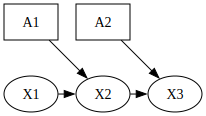

In [7]:
#| caption: Concatenating Bayes net fragments into a controlled Markov chain.
#| label: fig:controlled_markov_chain
A = VARIABLES.discrete_series("A", range(1, N), vacuum.action_space) # actions for times 1...N-1
bayesNet = gtsam.DiscreteBayesNet()
bayesNet.add(state_prior)
for k in range(1, N):
    bayesNet.add(X[k+1], [X[k], A[k]], vacuum.action_spec) # add creates conditional and adds
show(bayesNet, hints={"A":2, "X":1}, boxes={A[1][0],A[2][0]})

The example just shows the graphical model as produced by the three-state code fragment. It is not yet obvious how to obtain the posterior over $X_3$ in this two-step example. We explore that below.

### Exercise

Try varying the value of $N$ to create other examples.

```{index} forward simulation
```
```{index} sampling; from Markov chains
```
## Forward Simulation

> Sampling from Markov chains.

We can use simulation in a graphical model to explore what a sequence of
actions might yield as an outcome. 
Because the (controlled) Markov chains above are specified as a set of conditional distributions, and we have already seen how to sample from those, we just need to know in what order to sample them.
Indeed: to sample from a conditional distribution $p(X|Y)$ we need to make sure we sample the variable $Y$ *beforehand*, and then proceed simply by selecting the appropriate probability distribution,
depending on the value of $Y$. We can then
proceed as before using the inverse transform sampling method.

Forward sampling in a Markov chain simply repeats these steps in
succession, proceeding from left to right, because that ensures that we always have the condition before we attempt sampling from the conditional. 
Simulating a robot *given* an initial state $X_1$ and 
sequence of actions $a_{1}, a_{2},\ldots$ is then equivalent to sampling from this Markov chain:

1.  Set $k=1$, and we assume $X_1$ is known.

2.  Simulate the effect of the next action $A_k$ by sampling the next state
    $x_{k+1}$ from 
    \begin{equation}
    x_{x+1} \sim P(X_{k+1}|X_k=x_k,A_k=a_k).
    \end{equation}

3.  Increment $k$ and return to step $2$.

```{index} rollout
```
Figure [10](#fig:sample_markov_chain) illustrates how to code this up and shows 4 different **rollouts** by simulating in this way. 
Rollouts will be discussed in more detail in Section 3.5. 

In [8]:
#| caption: A simple example of sampling from a controlled Markov chain.
#| label: fig:sample_markov_chain
def sample(x1, a1, a2):
    values = VARIABLES.assignment({X[1]: x1, A[1]: a1})  # initial state and action
    x2 = vacuum.rooms[bayesNet.at(1).sample(values)]
    values = VARIABLES.assignment({X[2]: x2, A[2]: a2})  # next state and action
    x3 = vacuum.rooms[bayesNet.at(2).sample(values)]
    return [x1, x2, x3]


for i in range(4):
    print(sample("Office", "R", "U"))

['Office', 'Office', 'Office']
['Office', 'Hallway', 'Hallway']
['Office', 'Hallway', 'Living Room']
['Office', 'Office', 'Office']


While simple, simulating from a forward model is a rather important
technique, and underlies some of the recent successes in deep
reinforcement learning, as well as the success of DeepMind in beating
the world’s best players of the game of Go {cite:p}`Silver16_alphago`.

### Exercises

1. Generalize the above forward sampling algorithm to an arbitrary number of actions. Hint: you will have to make sure the variables are defined, and the graphical model is extended properly.
2. Empirically estimate the probability distribution of the final state by constructing a
histogram over the possible values of the state.

```{index} pair: Bayesian network; Bayes net
```
## Bayesian Networks

```{index} generative model
```
>  Bayes nets provide a graphical language to string together conditional probabilities into a generative world model.

```{index} pair: directed acyclic graph; DAG
```
```{index} factored probability distribution
```
A Markov chain is a special case of the more general **Bayesian network** or **Bayes net**.
A Bayes net is a directed *acyclic* graph (DAG) describing a factored
probability distribution over a set of random variables. 
By the term *factored probability distribution*, we mean that the
probability distribution is expressed as a product of factors, 
which in Bayes nets are always conditional distributions.

The code in Figure [11](#fig:general_bayes_net) uses GTSAM to creates a Bayes net, which we can then display.
We formally define Bayes nets below that.

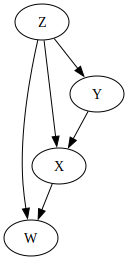

In [ ]:
#| caption: A general Bayes net on four discrete variables.
#| label: fig:general_bayes_net
wxyz = gtsam.DiscreteBayesNet()
W1 = VARIABLES.binary("W")
X1 = VARIABLES.binary("X")
Y1 = VARIABLES.binary("Y")
Z1 = VARIABLES.binary("Z")
wxyz.add(W1, [X1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(X1, [Y1, Z1], "1/1 1/1 1/1 1/1")
wxyz.add(Y1, [Z1], "1/1 1/1")
wxyz.add(Z1, "1/1")
show(wxyz)

The example Bayes net in Figure [11](#fig:general_bayes_net) is simply a graphical representation of which random variables’
CPT (conditional probability table) depend on which other variables.
Formally, in Bayes nets, the joint probability distribution $P(X_1, \dots , X_n)$ over a set
of random variables $X_1, \dots, X_n$ can be computed as the product of
$n$ conditional probabilities associated with each of the individual variables $X_i$ as
```{math}
:label: bn_is_product
P(X_1, \dots , X_n) = \prod_{i=1}^{n} P(X_{i} | \Pi_{i})
```
where $n$ is the number of variables, and $\Pi_{i}$ denotes the set of parents for variable
$X_{i}$ in the directed graph.

In the example, the joint distribution can then be read off as
\begin{equation}
P(W, X, Y, Z) = P(W | X, Z) P(X | Y, Z) P(Y | Z) P(Z).
\end{equation}
Note that the order in which
we multiply the conditionals does not matter, but we typically prefer to put the parents more towards the right, as above.
Finally, note that the above graph has cycles, but the cycles are only in the underlying *undirected* graph, not in the directed graph.
Directed cycles, i.e., cycles with a consistent direction, are not allowed.

Bayes nets can be very efficient representations of complex
probability distributions, as they encode the dependence and especially
independence relationships between the variables.
The Bayes net above was created assuming binary variables, and hence did not take
a lot of effort to specify, but as we saw above, even for relatively small state spaces 
the complexity of specifying CPTs can be daunting.

If we were to construct a full table of probabilities for each possible
outcome of the variables $W$, $X$, $Y$, and $Z$, the table could be quite long. 
For example, if we assume they all have 10 possible values, 
then the table required to represent the full joint distribution will have $10^{4}$ entries,
i.e., $10,000$ unique values. You
can save a tiny bit, because they have to sum up to 1, so strictly
speaking we need only $9,999$ values. In contrast, we can tally how many
entries all four CPT tables have for the Bayes net above. 
This is shown in the following table:

|     CPT     | \# entries |
|-------------|------------|
|   *P(Z)*    |      9     |
|  *P(Y\|Z)*  |     90     |
| *P(X\|Y,Z)* |     900    |
| *P(W\|X,Z)* |     900    |

For example, $P(X|Y,Z)$ has 900 entries, i.e., 9
(independent) entries for each of 100 possible combinations of $Y$ and
$Z$. Hence, the total number of parameters we need is only $1,899$,
which is significantly less than $9,999$.

### Exercise

What are the savings for the *binary* version of the graph that we created, i.e., where variables are either `True` or `False`? You should find the savings are much less.

## Factored State Representations*

> We can save even more by factoring the state.

Factored state representations are useful if the state of the robot can
be described using features that are relatively independent of each
other. Continuing our example, the robot vacuum cleaner might also run
out of battery power, so we could associate a different variable with
its battery status, e.g., `empty`, `half`, or `full`.
The state of the robot would then be specified by the combination of
two variables: the room the robot is in, and its battery status. 
Note that now the total number of possible states
is combinatorial: if there are five rooms and three different battery
levels, we have a total of 15 possible states for the robot.

A possible model for battery life could be the following transition table, which is independent of which action was taken, and will always progress from `full` to `half`, then from `half` to `empty`, and of course once the battery is empty it will stay empty:

In [10]:
battery_states = ["full", "half", "empty"]
B = VARIABLES.discrete_series("B", range(1,N+1), battery_states)
spec_b = "9/1/0 0/9/1 0/0/1 "
pretty(gtsam.DiscreteConditional(B[2], [B[1]], spec_b))

B1,full,half,empty
full,0.9,0.1,0
half,0,0.9,0.1
empty,0,0,1


The graphical model approach allows us to easily extend probabilistic
actions to factored state representations.
The code in Figure [12](#fig:factored_bayes_net) shows one way to do it.

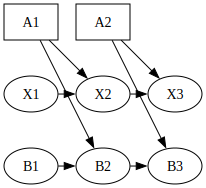

In [11]:
#| caption: A factored Bayes net for the vacuum cleaner problem.
#| label: fig:factored_bayes_net
factored = gtsam.DiscreteBayesNet()
factored.add(state_prior)
factored.add(B[1], [], "1/0/0") # initial battery state
for k in range(1, N):
    factored.add(X[k+1], [X[k], A[k]], vacuum.action_spec) # motion model for location
    factored.add(B[k+1], [A[k], B[k]], "".join([spec_b]*4)) # battery evolution model

show(factored, hints={"A":2, "X":1, "B":0}, boxes={A[1][0],A[2][0]})

You can see that under the transition models chosen, there are now Markov chains, and these are indpendent when the action sequence is *given*.

### Exercise
Note that the above model makes a number of strong statements about the nature of the world:
1. The next battery state does not depend on where we are in the world. This seems like an OK assumption. Still, can you think of situations where this is not a realistic assumption?
2. The next state does not depend on the battery life. Maybe this is not so defensible: clearly, if the battery is empty the robot cannot move, and the next state is the same as the previous state. It is worthwhile to think about what you would change above to make a more realistic model of the world.

## GTSAM 101

> The GTSAM concepts used in this section, explained.

As in Chapter 2, we once again used a `DiscreteConditional`, this time to specify a motion model for the controlled Markov chain above, as shown in Figure [4](#vacuum-motion-model).

To specify the motion model, we used the `DiscreteBayesNet` class, and in particular these methods:

- `add(self:, key: Tuple[int, int], parents: List[Tuple[int, int]], spec: str) -> None`: adds a conditional with the same arguments as the `DiscreteConditional` constructor.
- `at(self, i: int) -> gtsam.DiscreteConditional`: retrieves the $i^{th}$ conditional added.

In the last subsection we used a sleight of hand to extend the battery depletion model to depend on the navigation action.
The following is a bit of python code that replicates the battery specification `spec_b` four times:

In [12]:
# Replicate spec_b 4 times and print the result
spec = "".join([spec_b]*4)
print(spec)

9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 9/1/0 0/9/1 0/0/1 


We then made sure to specify the action *before* the previous battery state, so that the string above works out. In Figure [3.18](#fig:replicated_cpt) we pretty-print to  verify that this came out right. Of course, it is entirely possible to make the battery model *dependent* on the action chosen.

In [13]:
#| caption: CPT created by replicated specification.
#| label: fig:replicated_cpt
pretty(gtsam.DiscreteConditional(B[2], [A[2], B[1]], spec))

A2,B1,full,half,empty
L,full,0.9,0.1,0
L,half,0,0.9,0.1
L,empty,0,0,1
R,full,0.9,0.1,0
R,half,0,0.9,0.1
R,empty,0,0,1
U,full,0.9,0.1,0
U,half,0,0.9,0.1
U,empty,0,0,1
D,full,0.9,0.1,0


Finally, a word about the graphs above. You might wonder, why these graphs come out so beautifully positioned, e.g., to indicate time from left to right. This was accomplished with the `hints` argument, which positions variables series at an appropriate height. Similarly, the `boxes` argument (which takes `Keys`, not tuples) indicates which variables should considered as given.

These arguments are handled in the `gtbook` library {cite:p}`gtbook`, and are passed on in the appropriate format to the underlying GTSAM `dot` methods, which generate graphviz-style graphs{cite:p}`graphviz`.